In [5]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 64
psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

# Load PSFs

In [2]:
psfs_fpath = data_dir/'psfs'/'hlc_575_psfs_072022.fits'

psfs = fits.getdata(psfs_fpath)
print(psfs.shape, len(psfs))

(3577, 64, 64) 3577


NameError: name 'iwa' is not defined

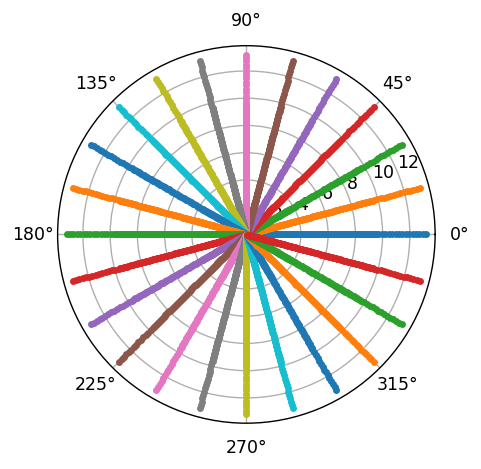

In [3]:
r_offsets_fpath = data_dir/'psfs'/'hlc_575_psfs_072022_radial_samples.fits'
thetas_fpath = data_dir/'psfs'/'hlc_575_psfs_072022_theta_samples.fits'

r_offsets = fits.getdata(r_offsets_fpath)
thetas = fits.getdata(thetas_fpath)*u.degree

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=125)
ax.plot(theta_offsets, r_offsets[1:], '.')
ax.set_rticks([iwa, owa, max(r_offsets)])  # Less radial ticks
ax.set_thetagrids(thetas.value)
ax.set_rlabel_position(55)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title('Distribution of PSFs', va='bottom')
plt.show()

In [39]:
len(r_offsets)

150

# Setup/Test the interpolating function

In [58]:
def find_closest_psf(xoff, yoff, verbose=True):
    r = np.sqrt(xoff**2+yoff**2)
    theta = np.arctan2(yoff,xoff).to(u.deg)
    if theta<0: theta += 360*u.deg
        
    kr = np.argmin(np.abs(r_offsets_mas-r))
    if kr>(len(r_offsets)-1):
        kr = len(r_offsets)-1
    kth = np.argmin(np.abs(thetas-theta))
    theta_diff = theta - thetas[kth] # use this to rotate the closest available PSF to the coordinate of interest
    
    if kr==0: 
        kpsf=0
    else: 
        kpsf = 1 + kth + (len(thetas))*(kr-1)
    
    if verbose: 
        print('Desired r={:.2f}, radial index={:d}, closest available r={:.2f}'.format(r, kr, r_offsets_mas[kr]))
        print('Desired th={:.2f}, theta index={:d}, closest available th={:.2f}, difference={:.2f}'.format(theta, kth, thetas[kth], theta_diff))
        print('PSF index = {:d}'.format(kpsf))
    
    closest_psf = psfs[kpsf]
    interpped_psf = rotate(closest_psf, -theta_diff.value, reshape=False, order=5)
    
    return interpped_psf


Desired r=200.00 mas, radial index=78, closest available r=200.76 mas
Desired th=0.00 deg, theta index=0, closest available th=0.00 deg, difference=0.00 deg
PSF index = 1849


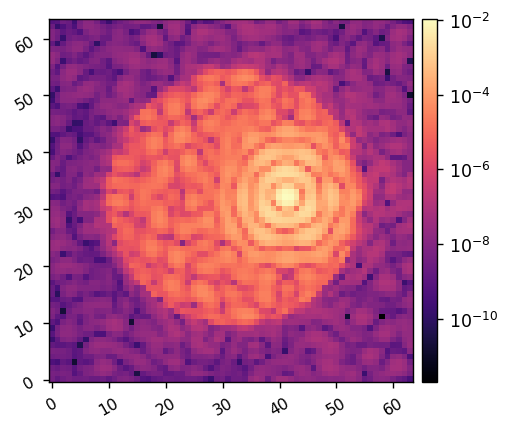

In [53]:
r = 200*u.mas
th = 0*u.deg
xoff = r*np.cos(th)
yoff = r*np.sin(th)
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

# Create the grid for which the interpolated PSFs will be calculated

In [54]:
ndisk = 128
disk_pixelscale_mas = 10.5*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix
x

<Quantity [-666.75, -656.25, -645.75, ...,  645.75,  656.25,  666.75] mas>

Desired r=942.93 mas, radial index=149, closest available r=627.37 mas
Desired th=225.00 deg, theta index=15, closest available th=225.00 deg, difference=0.00 deg
PSF index = 3568


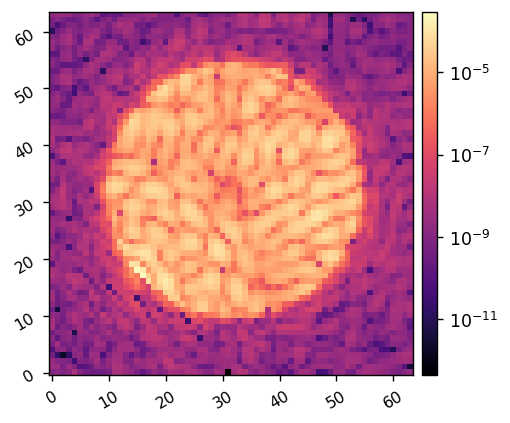

In [55]:
xoff = x[0]
yoff = y[0]
psf = find_closest_psf(xoff,yoff)

misc.myimshow(psf, lognorm=True)

In [60]:
ncols = ndisk**2
ipsf_matrix = np.zeros((npsf**2, ncols))

start=time.time()
for i in range(ncols):
    ipsf = find_closest_psf(x[i], y[i], verbose=False)
    ipsf_matrix[:,i] = ipsf.flatten() # assign the flattened psf to the column
    if i==ncols/8 or i==ncols/4 or i==ncols/2 or i==ncols*3/4 or i==ncols*7/8 or i==ncols-1:
        clear_output()
        print(i, time.time()-start)

16383 29.754797220230103


In [63]:
ipsf_matrix.shape

(4096, 16384)

In [64]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_072022.hdf5'
f = h5py.File(ipsf_fpath,'w')
f.create_dataset('ipsf_matrix', data=ipsf_matrix)
f.close()

In [ ]:
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_072022.hdf5'
f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()